In [1]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from fio import readin
from mpl_toolkits.mplot3d import Axes3D  

In [2]:
'''
    Initialization based on PM/Jonswap.
    All identities with _tile are two-dimensional array.
    In principle kmax = 2*np.pi/(2L/N_grid), kmin=2*np.pi/L.
''' 
# Function to convert polar to cartesian and interpolate
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

N_kmod = 64; N_theta = 64 # Uniform grid in kx and ky
kmod = np.linspace(0.2,4,N_kmod); theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
kmod_tile,theta_tile = np.meshgrid(kmod,theta)
kx_tile, ky_tile = pol2cart(kmod_tile, theta_tile)


# g = 9.81;  kp = 0.5;  cp = (g/kp)**0.5 # about 5m wavelength
# us = 0.77;  Bsat = 0.7;  ckz = Bsat/2*(cp/us)**(0.53)
# F_kmod_tile = ckz*us*g**(-1/2)*kmod_tile**(-2.5)*np.exp(-0.75*(kp/kmod_tile)**2)
kp = 2*np.pi/10 # peak at 10m
P = 0.3
F_kmod_tile = 0.3*kmod_tile**(-2.5)*np.exp(-0.75*(kp/kmod_tile)**2)
N = 10;  thetam = 0
D_theta_tile = np.cos(theta_tile-thetam)**N

dtt=2*pi./N
tangle=-pi/2:dtt:pi/2-dtt;
Na=50;
Gdir=cos(tangle).^Na;
ngn=trapz(tangle,Gdir);
GN=Gdir./ngn;%normalization to 1
trapz(tangle,GN)

F_kmodtheta_tile = F_kmod_tile*D_theta_tile
plt.imshow(F_kmodtheta_tile)
plt.xlabel('theta'); plt.ylabel('k')

SyntaxError: invalid syntax (<ipython-input-2-a85de1230ec1>, line 25)

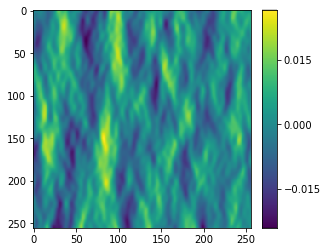

In [61]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10,4))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,1),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
pcontour = grid[0].imshow(eta_tile*kp)
grid[0].cax.colorbar(pcontour)

In [24]:
'''
    Add modes together to generate initial eta field.
'''
N_grid = 256 # Number of spatial grid in each direction
L = 50 # Domain size
phase_tile = np.random.random_sample(kx_tile.shape)*2*np.pi # Add a random phase field
x = np.linspace(-L/2,L/2,N_grid); y = np.linspace(-L/2,L/2,N_grid)
x_tile, y_tile = np.meshgrid(x, y)
eta_tile = np.zeros(x_tile.shape)
for i1 in range(0,N_grid):
    for i2 in range(0,N_grid):
        # How to exactly represent integrate over dk_x*dk_y*eta_hat?
        # mode = (F_kdirectional**0.5)*np.cos((kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+
        #                                    phase_tile)*(kmod_tile*(kmod[1]-kmod[0])*(theta[1]-theta[0])) # uniform space in k and theta
        a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+phase_tile
        mode = 0.5*((F_kmodtheta_tile)**0.5)*(np.cos(a)+np.sin(a))*((kmod[1]-kmod[0])*(theta[1]-theta[0])) # uniform space in kx and ky
#         mode = 1/64*0.5*((F_kmodtheta_tile)**0.5)*np.cos((kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+
#                                    phase_tile)*(kx[1]-kx[0]) # uniform space in kx and ky
        # The factor 0.5 is added so that the following check equals, not sure why yet...
        eta_tile[i1,i2] += np.sum(mode)

In [34]:
'''
    Initialize the velocity field by adding modes together.
'''
zb = -5; z_tile = zb # computational domain bottom position
N_layer = 5 # Number of layers used 
h_tile = eta_tile/N_layer # height of each layer (uniformly divided)
u_tile = np.zeros(x_tile.shape); v_tile = np.zeros(x_tile.shape); w_tile = np.zeros(x_tile.shape)
u_set = []; v_set = []; w_set = []; z_set=[] # For sanity checks
for l in tqdm(range(0, N_layer)):
    u_tile, v_tile, w_tile = np.zeros(x_tile.shape), np.zeros(x_tile.shape), np.zeros(x_tile.shape)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            # How to exactly represent integrate over dk_x*dk_y*eta_hat?
            # mode = (F_kdirectional**0.5)*np.cos((kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+phase_tile)*(kmod_tile*(kmod[1]-kmod[0])*(theta[1]-theta[0])) # uniform space in k and theta
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+phase_tile
            mode = 1/2**0.5*(0.5*(F_kmodtheta_tile)**0.5)*(np.cos(a))*((kmod[1]-kmod[0])*(theta[1]-theta[0]))
            # u = \sqrt{gk}*\eta_mode*sin(kx-wt), but also need to consider direction cos(theta)
            u_mode = (g*kmod_tile)**0.5*mode*np.exp(kmod_tile*z_tile[i1,i2])*np.cos(a)*np.cos(theta_tile)
            v_mode = (g*kmod_tile)**0.5*mode*np.exp(kmod_tile*z_tile[i1,i2])*np.cos(a)*np.sin(theta_tile)
            w_mode = (g*kmod_tile)**0.5*mode*np.exp(kmod_tile*z_tile[i1,i2])*np.sin(a)
            u_tile[i1,i2] += np.sum(u_mode); v_tile[i1,i2] += np.sum(v_mode); w_tile[i1,i2] += np.sum(w_mode)
    u_set.append(u_tile); v_set.append(v_tile); w_set.append(w_tile); z_set.append(z_tile)
    fu = open("/home/jiarong/research/projects/multilayer/testing/ftest_5layer_256/pre/u_layer%g" %l, "bw")
    u_output = u_tile.astype('float32'); u_output.tofile(fu)
    fv = open("/home/jiarong/research/projects/multilayer/testing/ftest_5layer_256/pre/v_layer%g" %l, "bw")
    v_output = v_tile.astype('float32'); v_output.tofile(fv)
    fw = open("/home/jiarong/research/projects/multilayer/testing/ftest_5layer_256/pre/w_layer%g" %l, "bw")
    w_output = w_tile.astype('float32'); w_output.tofile(fw)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2

100%|██████████| 5/5 [04:03<00:00, 48.76s/it]


In [35]:
'''
    Check KE and GPE equal partition.
'''
# To do: compute gpe from z_set
gpe = 0.5*np.sum(eta_tile**2)*(L/N_grid)**2*9.8
print(gpe)
ke = 0
for ilayer in range(0,N_layer):
    ke += (np.sum(u_set[ilayer]**2)+np.sum(v_set[ilayer]**2)+np.sum(w_set[ilayer]**2))*(L/N_grid)**2*(0-zb)/N_layer
print(ke)

3.1131901357152856
263.4656652702875


In [26]:
'''
    Check that calculation of F(kmod) is consistent by comparing integration of F(kmod) and mean square
    of the initial eta field.
'''
F_integrated = np.sum(F_kmodtheta_tile)*((kmod[1]-kmod[0])*(theta[1]-theta[0])) # Integration over kx ky is easier

print(F_integrated)
print(np.sum((eta_tile-np.average(eta_tile))**2)*(L/N_grid)**2) # Notice the Delta x normalization
print(np.std(eta_tile)*kp)
print(np.average(eta_tile))

0.34771052715259443
0.6353440627866466
0.007970847274829988
1.857815420250268e-05


In [32]:
test = np.array([4, 2, -9])
np.std(test)**2

32.666666666666664

In [59]:
a = np.array([[1,0,-1/2,0],[0,1,0,-3/2],[0,0,3/2,0],[0,0,0,5/2]]) 
inv_a = np.linalg.inv(a)

In [57]:
b = np.array([[1,0,1,0],[0,1,0,-3],[0,0,2,0],[0,0,0,4]]) 
inv_b = np.linalg.inv(b)

In [60]:

result = np.dot(inv_b, a)
print(result)

[[ 1.     0.    -1.25   0.   ]
 [ 0.     1.     0.     0.375]
 [ 0.     0.     0.75   0.   ]
 [ 0.     0.     0.     0.625]]


In [58]:
inv_b

array([[ 1.  ,  0.  , -0.5 ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.75],
       [ 0.  ,  0.  ,  0.5 ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.25]])